scraped  2196  publications


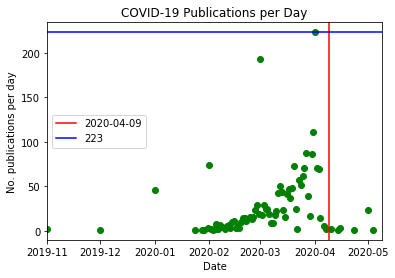

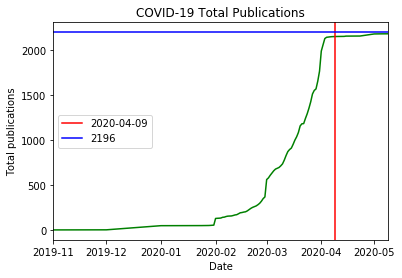

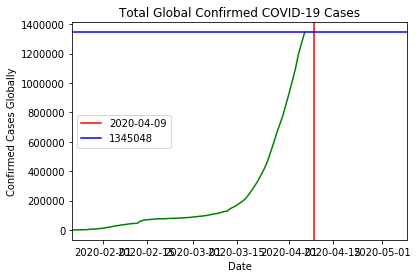

In [2]:
from ebsco import ebscoDataReader as ebsco
from jhu_covid19 import covidDataReader as covid
from utils import plotData

import os

slash = os.path.sep
# scrapeRawData
path = "ebsco"+slash+"rawData.xml"
entries = ebsco.buildDataset(path, "COVID-19");
ebsco.writeCSV('csvData.csv', entries);
print("scraped ", len(entries), " publications")

ebscoCount = ebsco.buildDailyPublishCount(entries)
plotData.plotDaily(ebscoCount, 
            ylabel = "No. publications per day", 
            title = "COVID-19 Publications per Day", 
            todayCol = 'r', 
            maxCol = 'b', 
            fmt = 'go',
            saveFmt = 'svg')
ebscoSum = ebsco.buildDailyPublishSum(ebscoCount)
plotData.plotDaily(ebscoSum, 
            ylabel = "Total publications", 
            title = "COVID-19 Total Publications", 
            todayCol = 'r', 
            maxCol = 'b', 
            fmt = 'g-',
            saveFmt = 'svg')

# buildGlobalSum

# Build time series data for confirmed, deaths, recovered cases
path = "jhu_covid19"+slash+"COVID-19"+slash+"csse_covid_19_data"+slash+"csse_covid_19_time_series"+slash
covidConf, covidDead, covidRec = covid.buildDataset(path)

plotData.plotDaily(covidConf, 
            ylabel = "Confirmed Cases Globally", 
            title = "Total Global Confirmed COVID-19 Cases", 
            todayCol = 'r', 
            maxCol = 'b', 
            fmt = 'g-',
            saveFmt = 'png')
plotData.plotDaily(covidDeath, 
            ylabel = "Confirmed Deaths Globally", 
            title = "Total COVID-19 Deaths", 
            todayCol = 'r', 
            maxCol = 'b', 
            fmt = 'g-',
            saveFmt = 'png')
plotData.plotDaily(covidRecov, 
            ylabel = "Recovered Globally", 
            title = "Total COVID-19 Recovered", 
            todayCol = 'r', 
            maxCol = 'b', 
            fmt = 'g-',
            saveFmt = 'png')
